In [1]:
import pandas as pd
import numpy as np
import networkx as nx 
import seaborn as sns
import math

files_history = ["data/nltk/nltk_files_history.csv", "data/wagtail/wagtail_files_history.csv"]
commits_history = ["data/nltk/nltk_commits_history.csv", "data/wagtail/wagtail_commits_history.csv"]
files_columns = ["Repository", "Branches", "NbBranches", "OldFilePath", "FilePath", "FileName", "FileExtension", "FileType", 
                    "ChangeType", "NbMethods", "NbMethodsChanged", "NLOC", "Complexity", "NlocDivByNbMethods", 
                    "ComplexDivByNbMethods", "SATD", "SATDLine", "NbLinesAdded","NbLinesDeleted", "CommitId", "Author", "DateTime", 
                    "Date", "HourOfDay"]

files_pd = [pd.read_csv(file, header=None, names=files_columns) for file in files_history]
files_pd_all = pd.concat(files_pd)
files_pd_all["DateTime"] = pd.to_datetime(files_pd_all["DateTime"],format="%Y-%m-%d %H:%M:%S%z",utc=True)
files_pd_all["Date"]  = files_pd_all["DateTime"].dt.date
commits_pd = [pd.read_csv(file) for file in commits_history]

In [280]:
files_pd_all[["Repository", "Branches"]].drop_duplicates()

,Repository,Branches
0,nltk,{'develop'}
0,wagtail,{'main'}


In [281]:
files_pd_all[["Repository", "FileName"]].drop_duplicates().groupby(["Repository"]).size().reset_index(name="count")

,Repository,count
0,nltk,644
1,wagtail,1283


In [301]:
files_pd_all[["Repository", "ChangeType"]].groupby(["Repository", "ChangeType"]).size().reset_index(name="count")

,Repository,ChangeType,count
0,nltk,ADD,1034
1,nltk,DELETE,660
2,nltk,MODIFY,19702
3,nltk,RENAME,491
4,nltk,UNKNOWN,7
5,wagtail,ADD,2002
6,wagtail,DELETE,651
7,wagtail,MODIFY,20566
8,wagtail,RENAME,1163
9,wagtail,UNKNOWN,2


In [311]:
distributions = files_pd_all[["Repository", "Branches", "CommitId", "Author"] + files_columns[9:19]]

distributions_long = pd.melt(distributions, id_vars=["Repository",  "Branches", "CommitId", "Author"], value_vars=files_columns[9:19])

In [324]:
g = sns.FacetGrid(distributions_long, hue="Repository", col = "variable",  col_wrap = 3, sharex = False, sharey = False)
g.add_legend()
g.figure.set_size_inches(24, 12) 
g.map_dataframe(sns.histplot, x = "value").set(xscale="log")

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
/var/data/python/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: Glyph 9 (	) missing from current font.
  self._figure.tight_layout(*args, **kwargs)


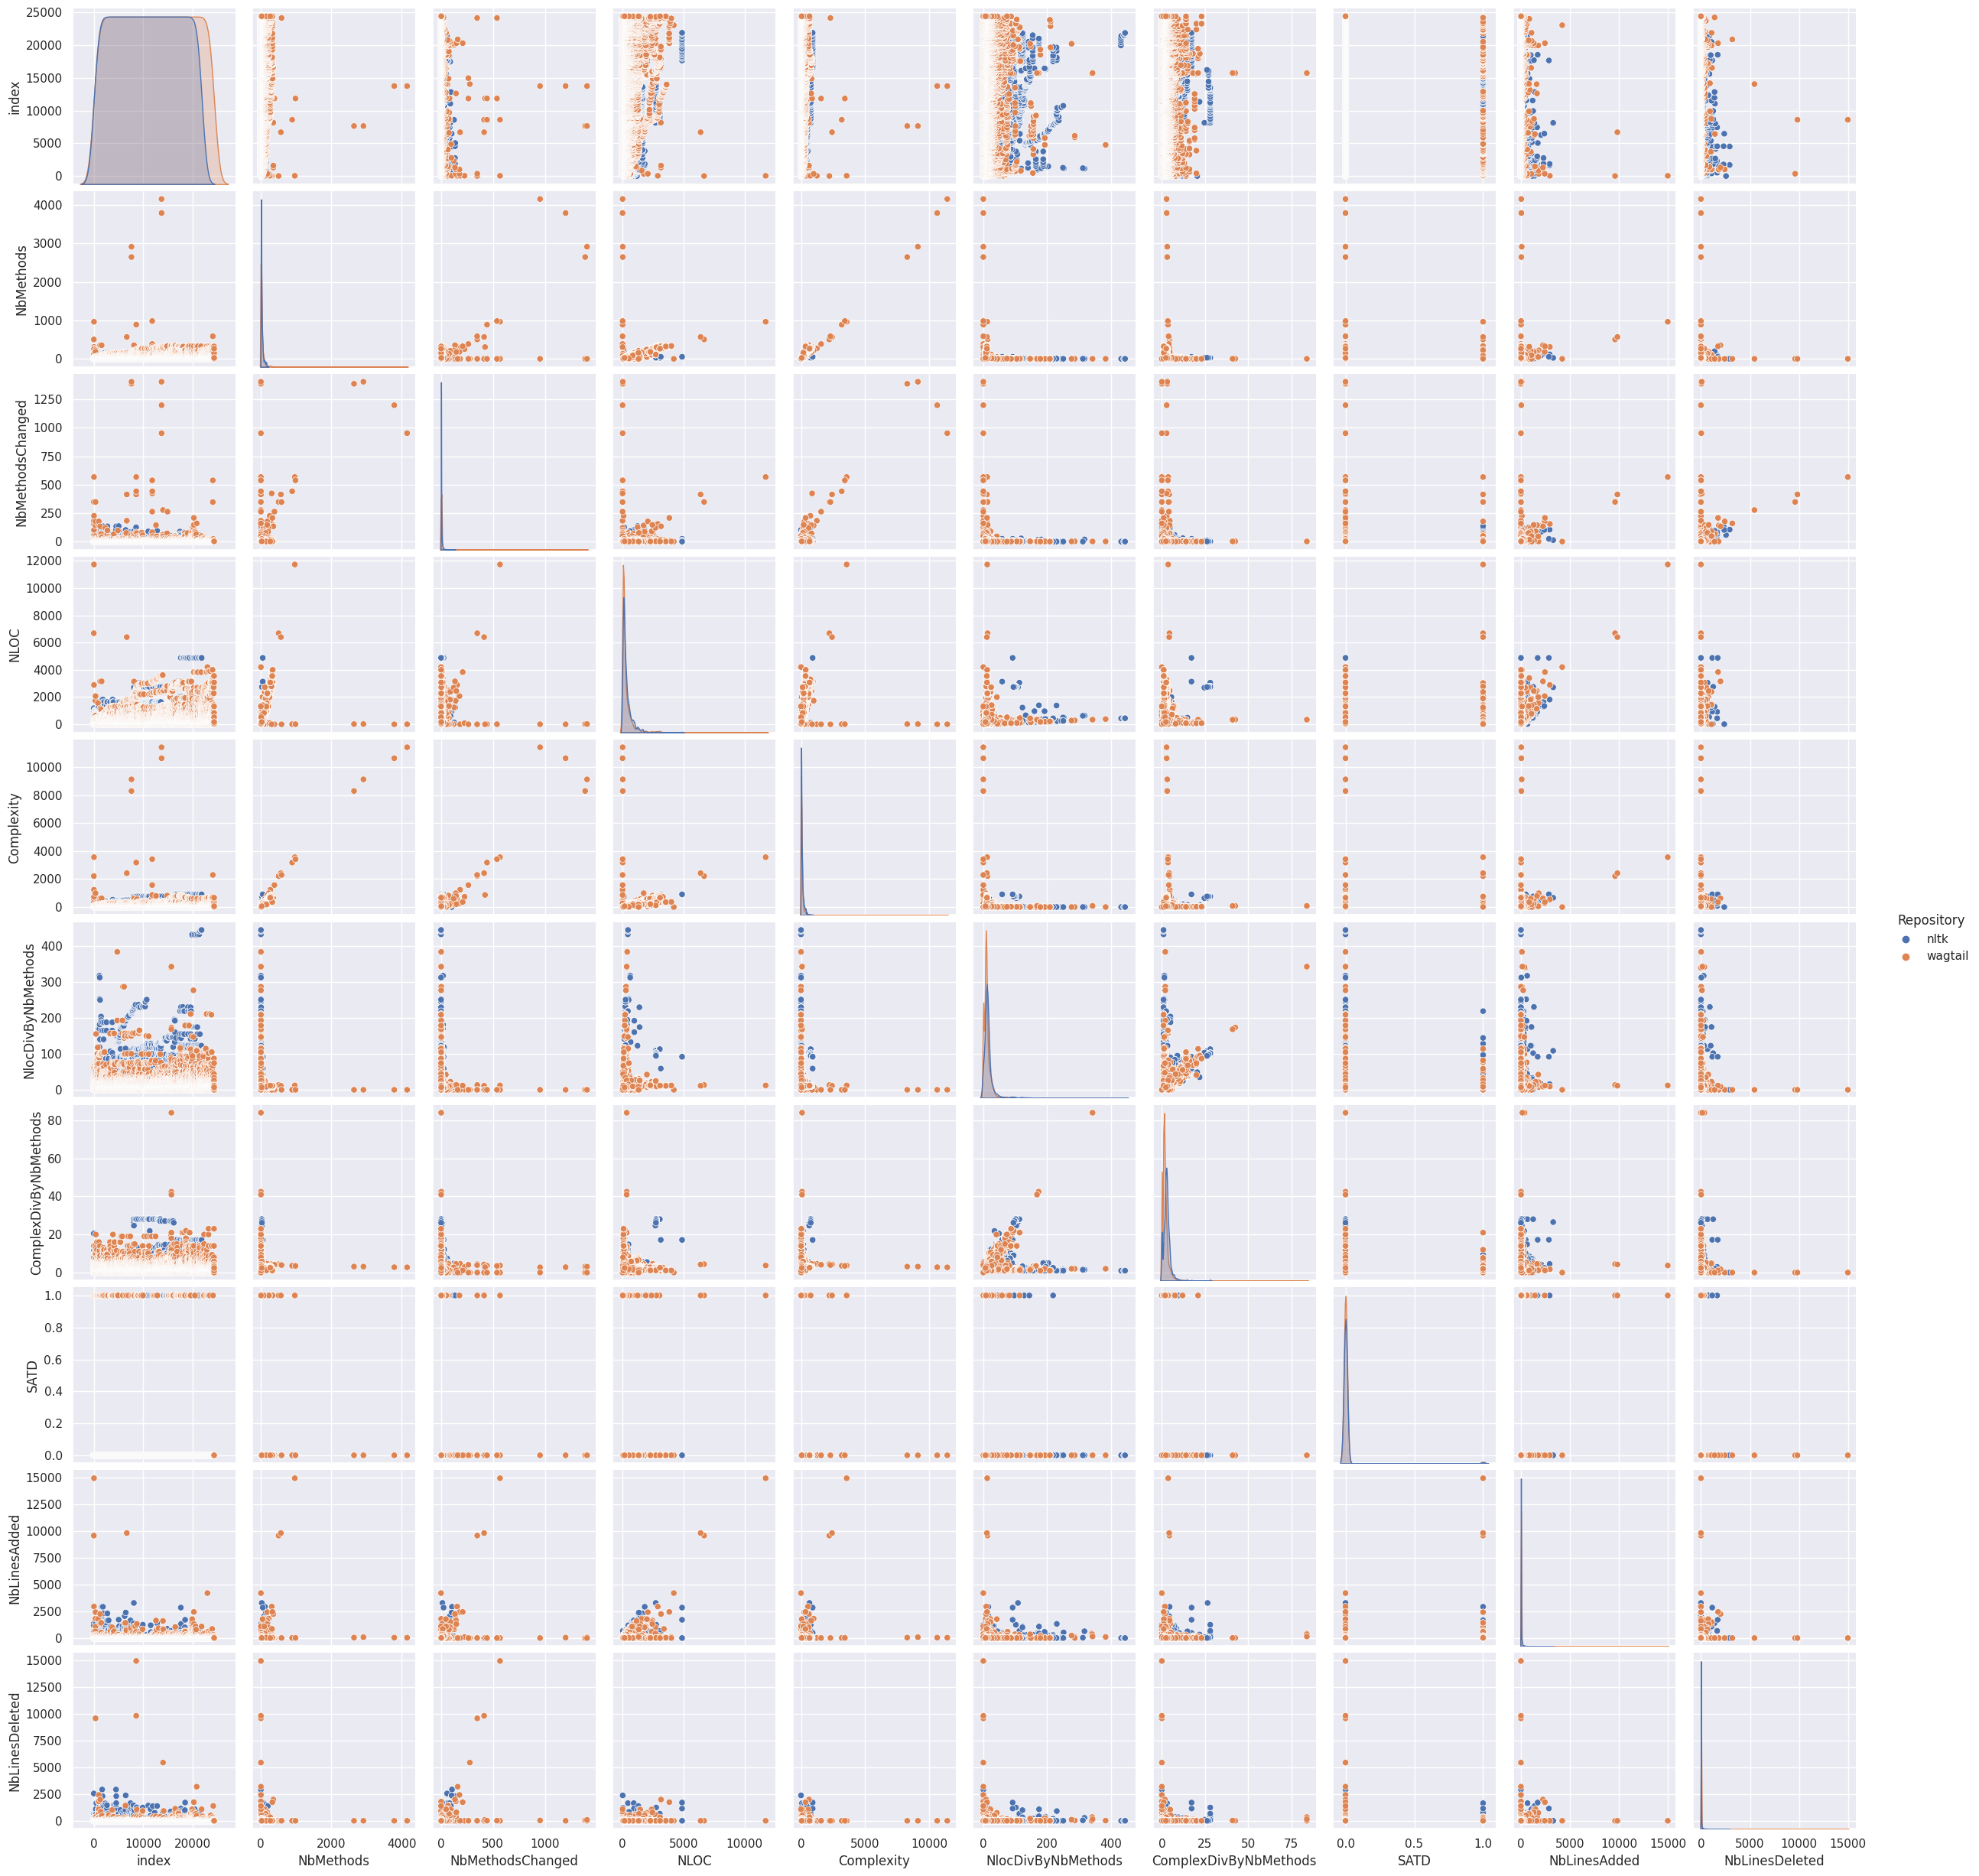

In [ ]:
sns.pairplot(files_pd_all[["Repository"] + files_columns[9:19]].reset_index(drop=True), hue="Repository")

## Basic Exploration, File Changes over Time

In [21]:

commits_time = files_pd_all[["DateTime", "Repository", "ChangeType", "NbBranches"]]
commits_time["Week"] = commits_time["DateTime"].dt.floor("7D")
commits_time = commits_time.groupby(["Week", "Repository", "ChangeType"]).count().reset_index()

commits_time = commits_time.rename(columns = {"NbBranches": "count"})

/tmp/ipykernel_303/971838425.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commits_time["Week"] = commits_time["DateTime"].dt.floor("7D")


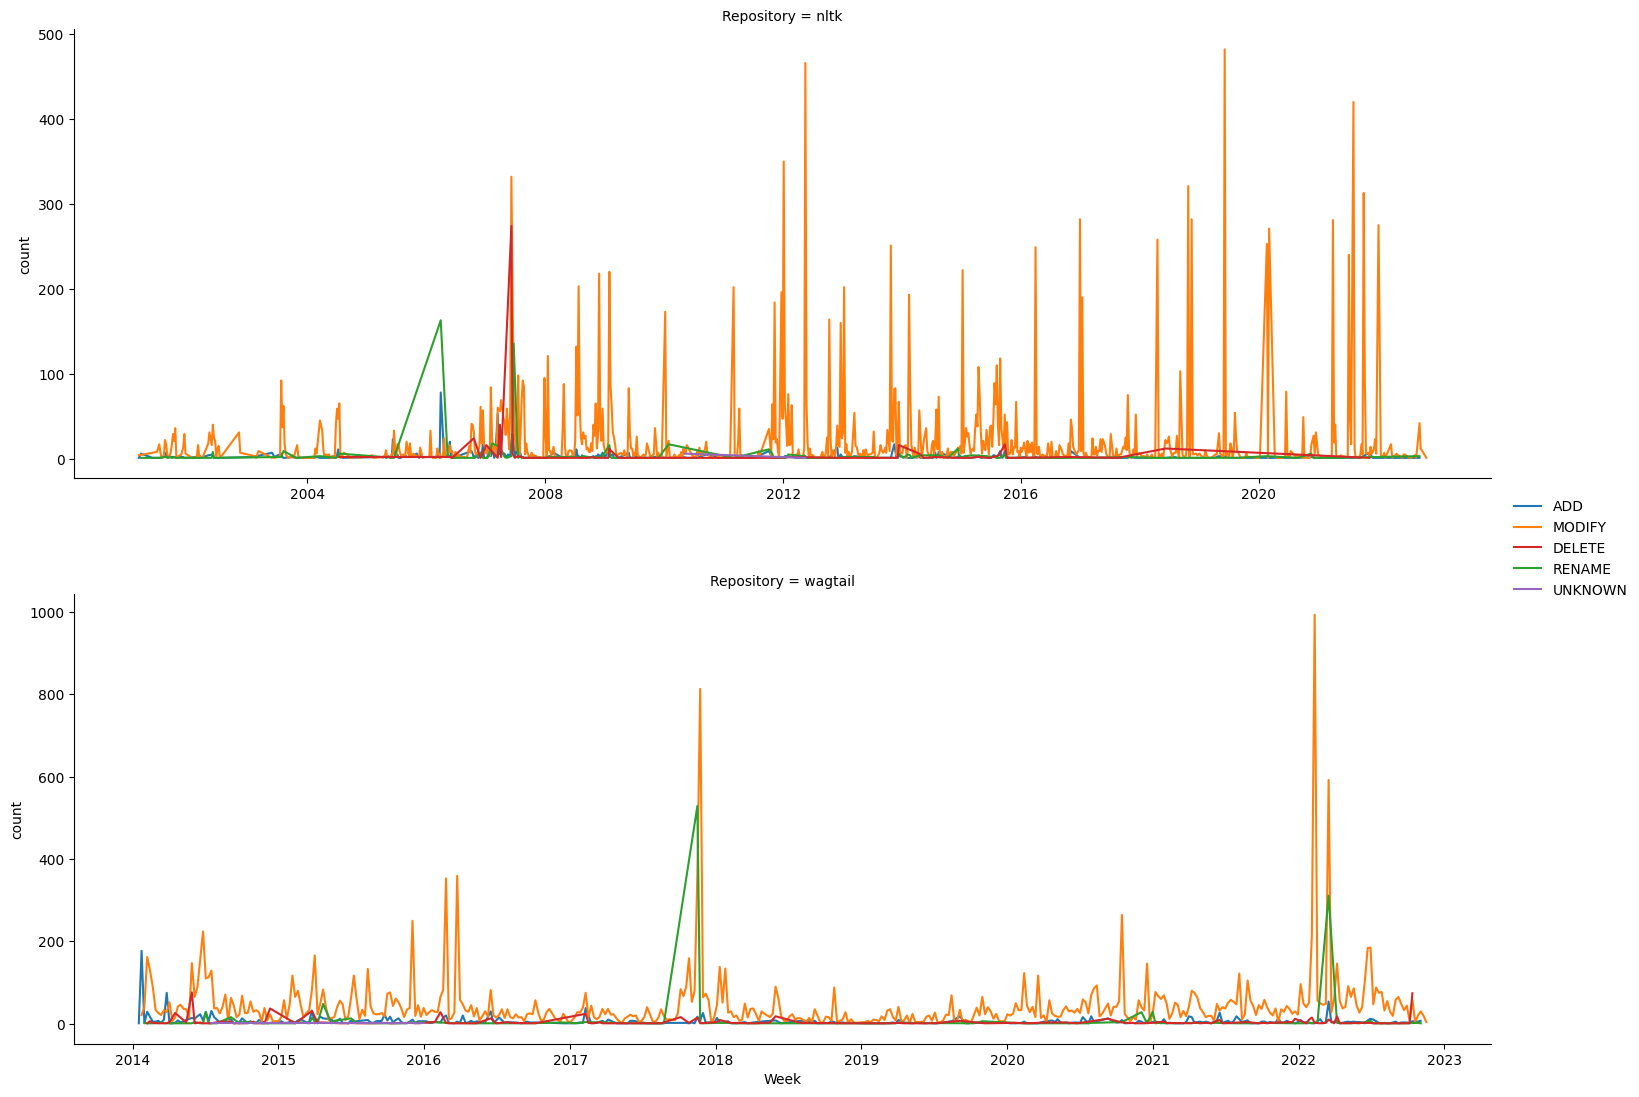

In [27]:

g = sns.FacetGrid(commits_time, col="Repository", col_wrap = 1, sharex = False, sharey = False)
g.map_dataframe(sns.lineplot, x="Week", y="count", hue = "ChangeType")
g.figure.set_size_inches(20, 12) 
g.add_legend()

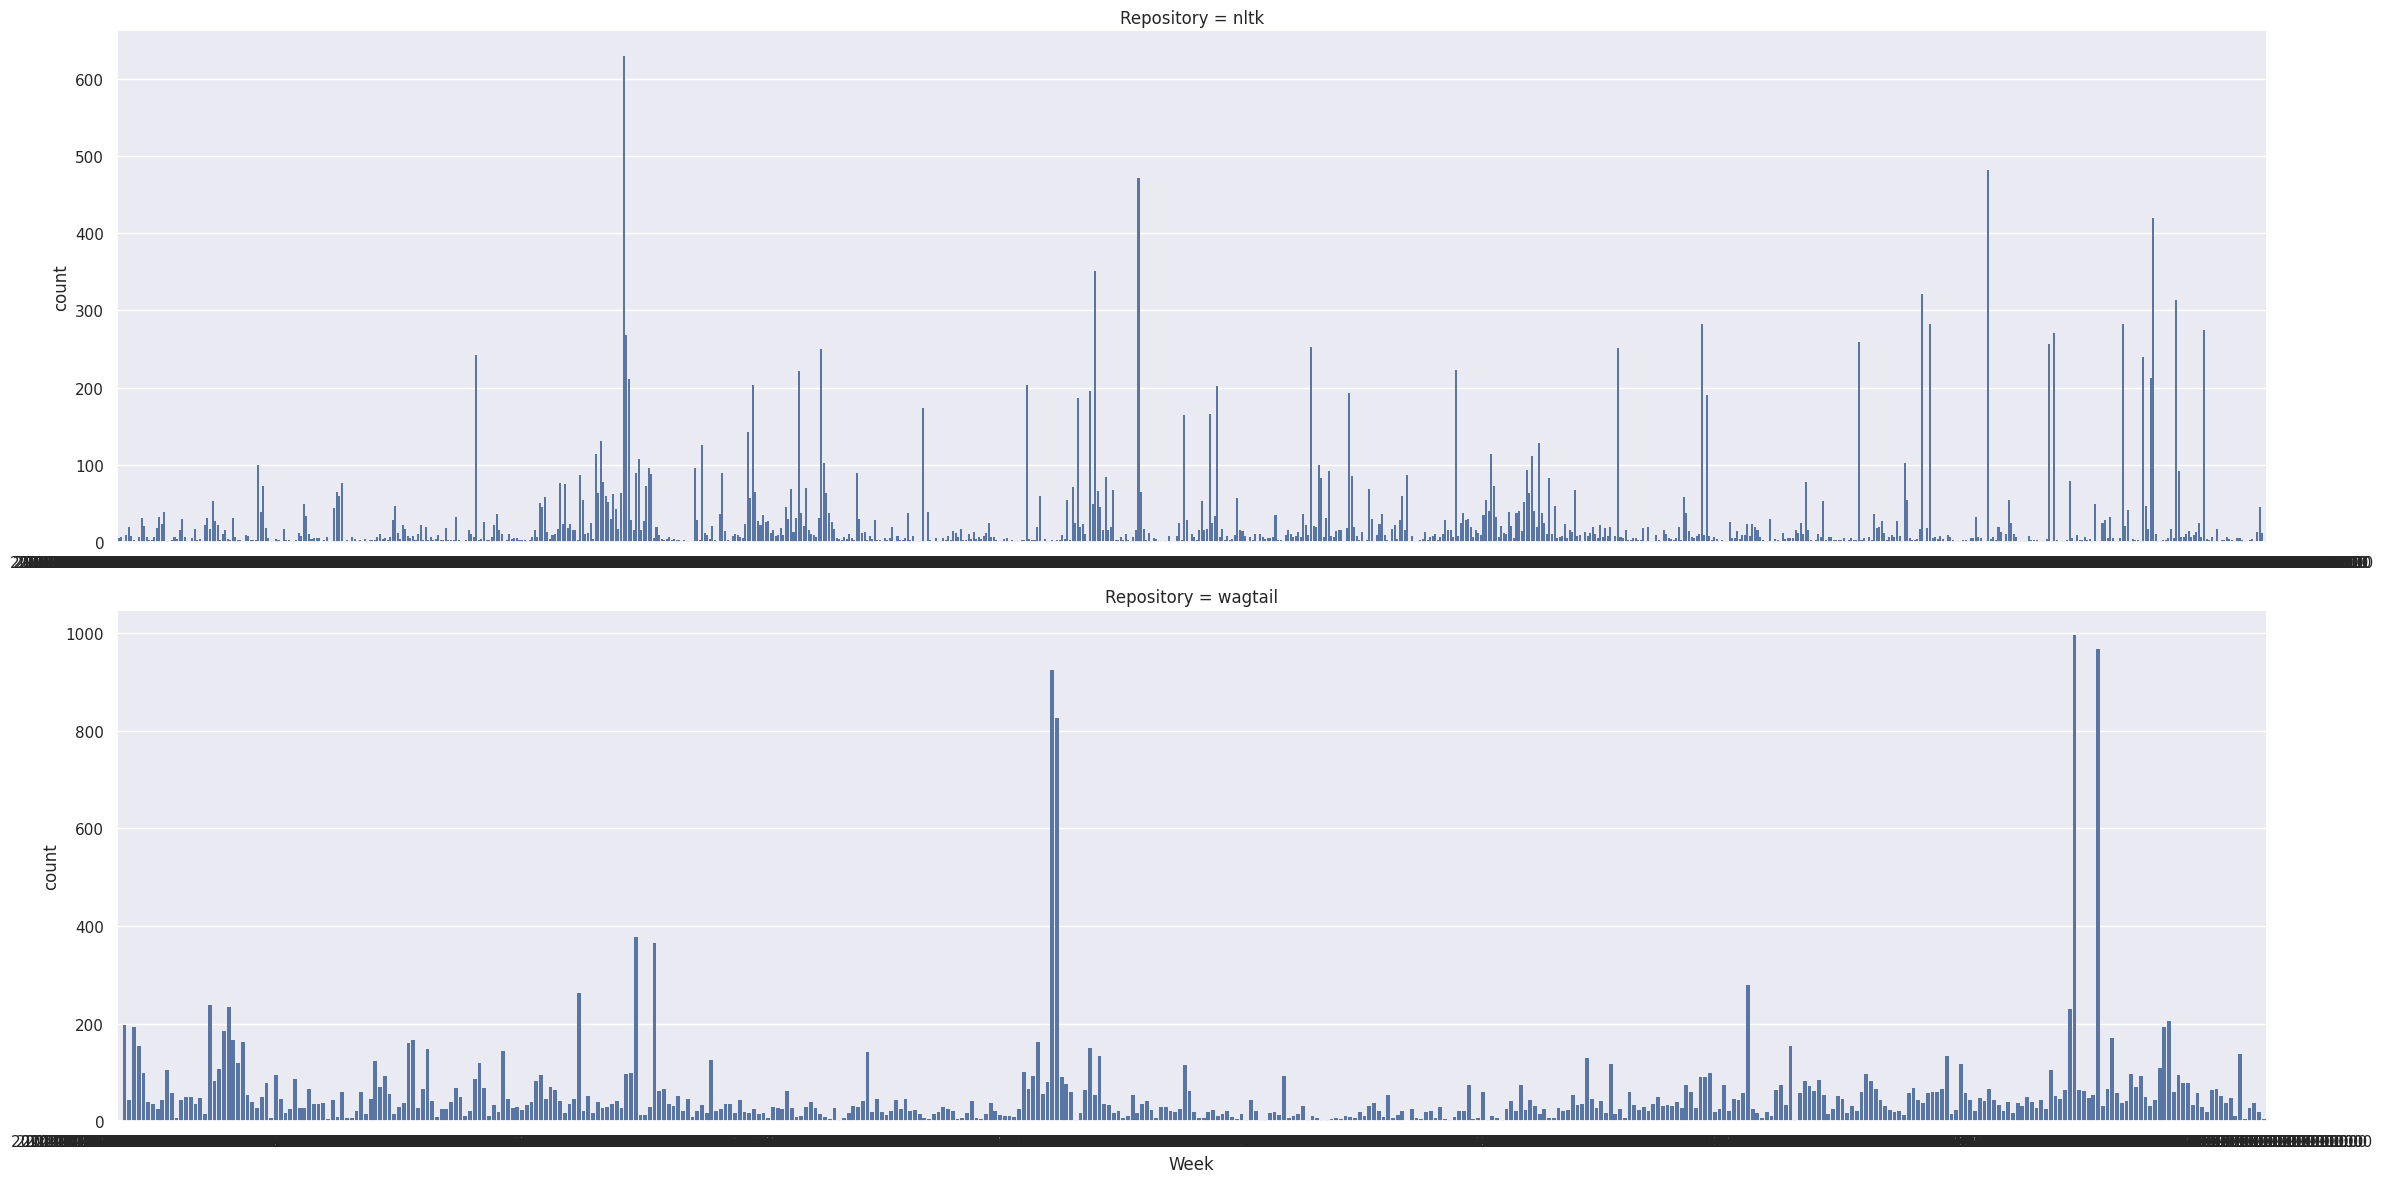

In [273]:
commits_week = files_pd_all
commits_week["Week"] = commits_week["DateTime"].dt.floor("7D")
commits_week = commits_week.groupby(["Week", "Repository"]).count().reset_index()
commits_week = commits_week[["Week", "Repository", "Branches"]] 
commits_week = commits_week.rename(columns = {"Branches": "count"})

g = sns.FacetGrid(commits_week, col="Repository",  col_wrap = 1, sharex = False, sharey = False)
g.figure.set_size_inches(24, 12) 
g.map_dataframe(sns.barplot, x="Week", y="count", lw=0)


## Commits by Author

In [257]:
def get_rank_grp_log10(df):
    df["rank"]  = df["count"].rank(ascending=False)
    df["rank"] = df["rank"].apply(lambda x: math.log10(x))
    df["count"] = df["count"].apply(lambda x: math.log10(x))
    return df


In [252]:
commits_contributor = files_pd_all.groupby(["Author", "Repository"]).size().reset_index(name="count")

In [260]:
commits_contributor_grp = commits_contributor.groupby(["Repository"])
commits_contributor_rank = [get_rank_grp_log10(df) for _, df in commits_contributor_grp]
commits_contributor_rank_all = pd.concat(commits_contributor_rank)

/tmp/ipykernel_7421/2471264729.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  commits_contributor_rank = [get_rank_grp_log10(df) for _, df in commits_contributor_grp]


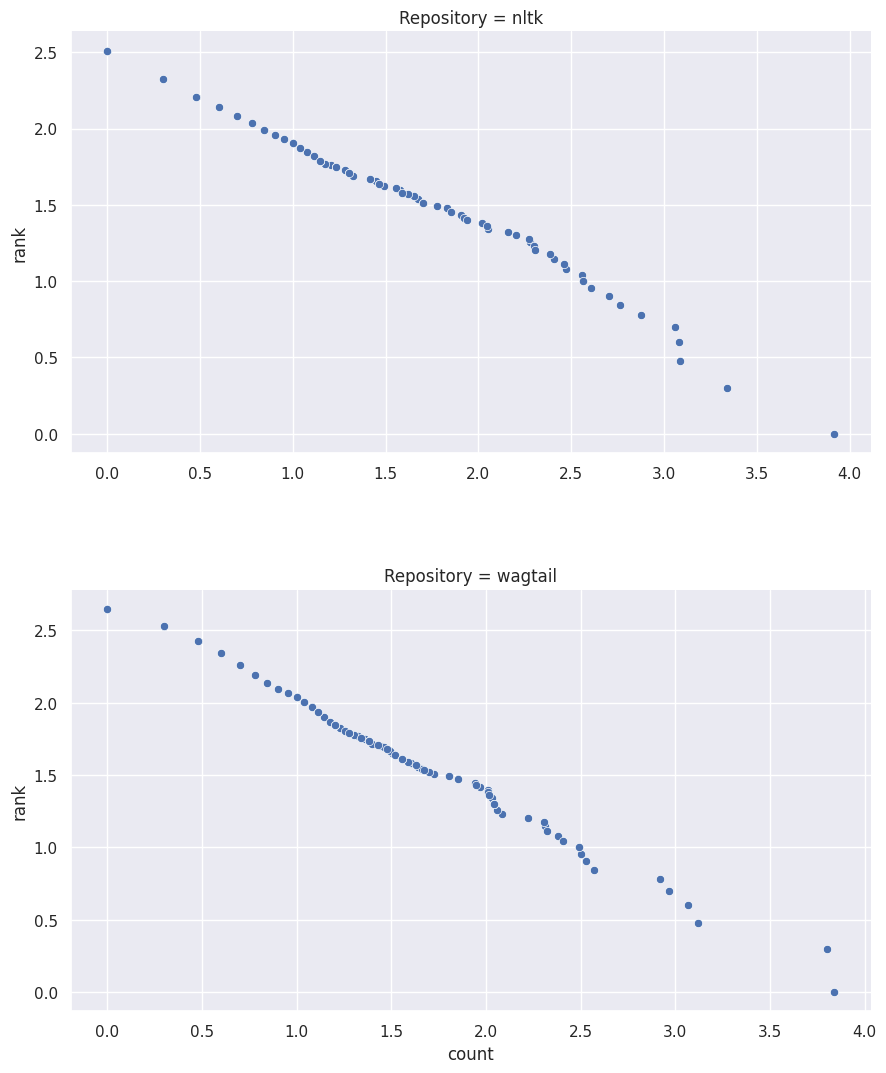

In [262]:
g = sns.FacetGrid(commits_contributor_rank_all, col="Repository",  col_wrap = 1, sharex = False, sharey = False)
g.map_dataframe(sns.scatterplot, x="count", y="rank", lw=0)
g.figure.set_size_inches(12, 12) 

# Plan

1. Create co-authorship graphs by file commit (commiting to the same file, within a certain time frame)
2. Count edges by time window, determine where it levels out (time to try - day, week, month, quarter)
3. Determine ideal time window, create graphs from this window
4. Extract network statistics for each timestep
5. Visualize these statistic over time

Note: Steps 3-5 can be done together (don't neceesarily need to create persistent graph objects)

In [184]:
import math

def rolling_with_name(df, nm, timescale):
    df_rolled = df.rolling(timescale, min_periods = 1).count().reset_index()
    df_rolled["Repository"] = nm[0]
    df_rolled["FileName"] = nm[1]
    df_rolled = df_rolled.rename(columns = {"Author": "count"}, errors = "raise")
    df_rolled["total_edges"] =  df_rolled["count"].apply(lambda x: math.comb(int(x), 2))
    total_ts = df_rolled.groupby(["Repository", "DateTime"]).agg({"total_edges": "sum"}).reset_index()
    total_ts["timescale"] = int(timescale.replace("D", ""))
    return  total_ts

def timescale_count_contributors(df, timescale):
    df = df[["Repository", "DateTime", "FileName", "Author"]]
    df = df.drop_duplicates()
    #df = df.set_index(["DateTime"])
    df = df.sort_index()
    edge_counts_file = df.groupby(["Repository", "FileName"])
    edge_counts_rolling = [rolling_with_name(df, nm, timescale) for nm, df in edge_counts_file]
    return pd.concat(edge_counts_rolling)

In [194]:
time_intervals = ["1D", "3D", "7D", "14D", "30D", "60D", "90D"]
counts_by_time = [timescale_count_contributors(files_pd_all, interval) for interval in time_intervals]
counts_by_time_all = pd.concat(counts_by_time)

In [195]:
avg_counts_by_time_repo = counts_by_time_all.groupby(["timescale", "Repository"]).agg({"total_edges": "mean"}).reset_index()

In [197]:
sns.lineplot(x = "timescale", y = "total_combos", hue = "Repository", data = avg_counts_by_time_repo)


ValueError: Could not interpret value `total_combos` for parameter `y`

<AxesSubplot: xlabel='DateTime', ylabel='total_edges'>

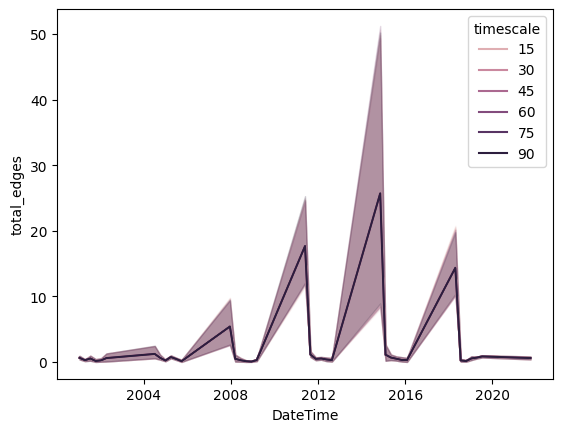

In [190]:

sns.lineplot(x = "DateTime", y = "total_edges", hue = "timescale", data = counts_by_time_all.query("Repository == 'nltk'"))
